# 1. IMPORT DEPENDENCES

In [10]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2



In [11]:
tf.__version__

'2.15.0'

# 2. GET THE DATA READY FOR TRAINING

In [12]:
path = r"D:\Lung cancer\train"
for files in os.listdir(path):
    print(os.path.join(path,files))

D:\Lung cancer\train\adenocarcinoma
D:\Lung cancer\train\large.cell.carcinoma
D:\Lung cancer\train\normal
D:\Lung cancer\train\squamous.cell.carcinoma


Then we set the path for this data.

In [13]:
train_path = r"D:\Lung cancer\train"
valid_path = r"D:\Lung cancer\valid"
test_path = r"D:\Lung cancer\test"

In [14]:
image_paths = [r'D:\Lung cancer\train\adenocarcinoma', r'D:\Lung cancer\train\large.cell.carcinoma',
r'D:\Lung cancer\train\normal', r'D:\Lung cancer\train\squamous.cell.carcinoma']

def load_images(image_paths=image_paths, n=36, resize_dims=(430, 305)):
    # Load the images from disk.
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(os.path.join(image_paths[i], path)) for path in os.listdir(image_paths[i])[:int(n/4)]]
        
        # Resize each image to the specified dimensions
        resized_images = [cv2.resize(img, resize_dims) for img in images_]
        
        images.append(resized_images)
    
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample


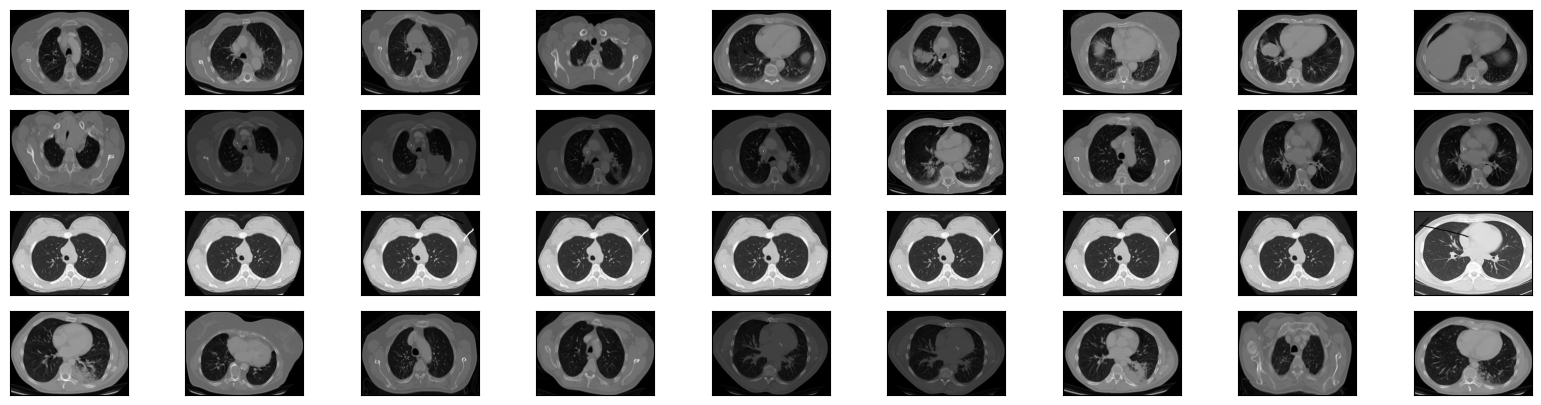

In [15]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

In [16]:
np.array(shapes).mean(axis=0)


array([305., 430.,   3.])

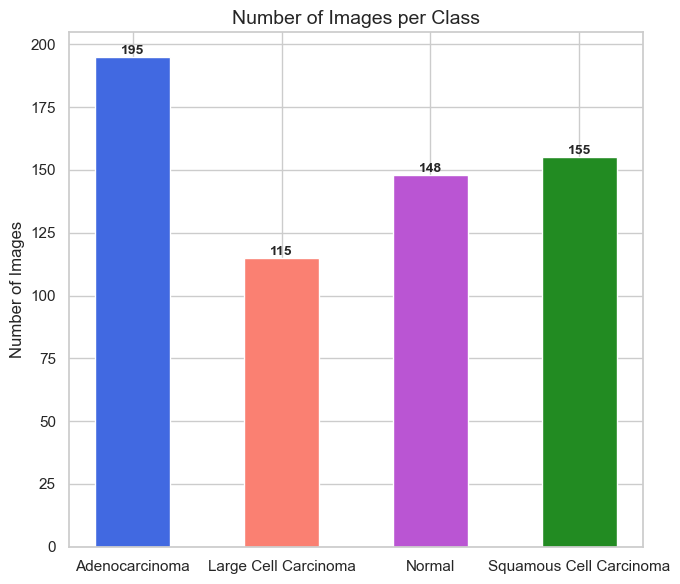

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Define the path to your dataset directory
dataset_path = r"D:\Lung cancer\train"

# Mapping dictionary to associate folder names with class names
class_mapping = {
    'adenocarcinoma': 'Adenocarcinoma',
    'large.cell.carcinoma': 'Large Cell Carcinoma',
    'normal': 'Normal',
    'squamous.cell.carcinoma': 'Squamous Cell Carcinoma'
}

# Initialize an empty dictionary to store the count of images for each class
class_count = {}

# Iterate over each subfolder (class) in the dataset directory
for folder_name, class_name in class_mapping.items():
    class_path = os.path.join(dataset_path, folder_name)
    
    # Check if the path is a directory
    if os.path.isdir(class_path):
        # Count the number of images in the subfolder
        num_images = len(os.listdir(class_path))
        
        # Store the count in the dictionary with the class name as the key
        class_count[class_name] = num_images

# Define custom colors for each class
custom_colors = ['royalblue', 'salmon', 'mediumorchid', 'forestgreen']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 6))

# Set a thinner width for the bars
bar_width = 0.5  # Adjust this value to make the bars thinner or thicker

# Create vertical bar plot with custom colors and thinner width
bars = ax.bar(list(class_count.keys()), list(class_count.values()), color=custom_colors, width=bar_width)

# Add data labels on top of each bar with bold text
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{int(height)}', va='bottom', ha='center', fontsize=10, fontweight='bold')

# Set labels and title

ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Number of Images per Class', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()


# 3. IMAGE PREPROCESSING

* When using Gradient Descent, We should ensure that all Features have a similar scale, otherwise, it will take much longer to converge.

In [54]:
image_shape = (430, 305, 3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (430, 305),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (430, 305),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (430, 305),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# 4. BUILDING THE MODEL ARCHITECTURE

In [55]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    #Conv2D(filters = 64 , kernel_size = 2, padding = 'same', activation = 'relu',
     #     kernel_regularizer = regularizers.l2(weight_decay)),
    #MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')
    
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 430, 305, 8)       104       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 215, 152, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 215, 152, 16)      528       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 107, 76, 16)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 107, 76, 16)       0         
                                                                 
 flatten_5 (Flatten)         (None, 130112)           

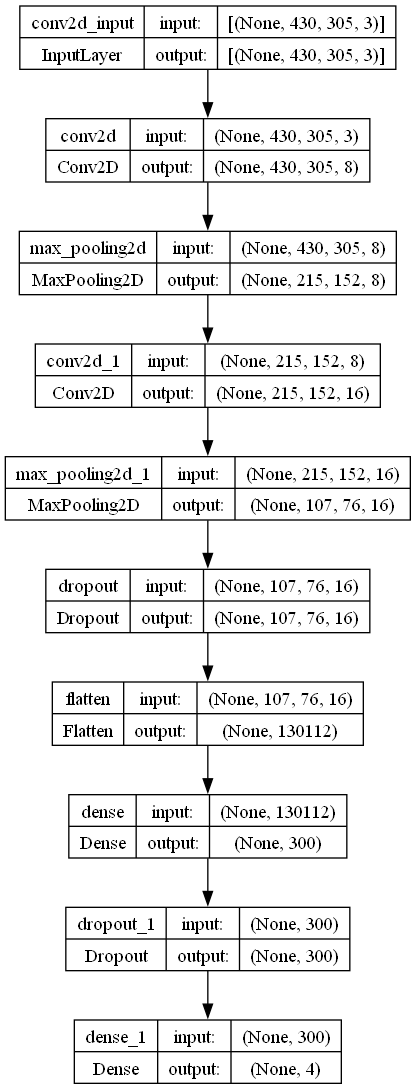

In [28]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='D:\Lung cancer\model images\model_convcnn.png', show_shapes=True, show_layer_names=True)


In [101]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

# 5. TRAIN THE MODEL

In [157]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import optimizers

# Define the learning rate schedule
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9
)

# Create an optimizer with the learning rate schedule
optimizer = Adam(learning_rate=learning_rate_schedule)

# ModelCheckpoint callback to save the best weights
checkpointer = ModelCheckpoint('chestmodel.hdf5', verbose=1, save_best_only=True)

In [158]:
# EarlyStopping callback to stop training if validation loss doesn't improve for 15 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [159]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=100,
    verbose=1,
    validation_data=valid_generator,
)

Epoch 1/100
20/20 [==============================] - 17s 785ms/step - loss: 1.3417 - acc: 0.3344 - val_loss: 1.3846 - val_acc: 0.3889
Epoch 2/100
20/20 [==============================] - 9s 467ms/step - loss: 1.2505 - acc: 0.4405 - val_loss: 1.3404 - val_acc: 0.3889
Epoch 3/100
20/20 [==============================] - 9s 452ms/step - loss: 1.1946 - acc: 0.4910 - val_loss: 1.3078 - val_acc: 0.4167
Epoch 4/100
20/20 [==============================] - 9s 467ms/step - loss: 1.1536 - acc: 0.4633 - val_loss: 1.2580 - val_acc: 0.4167
Epoch 5/100
20/20 [==============================] - 9s 454ms/step - loss: 1.1139 - acc: 0.5253 - val_loss: 1.2262 - val_acc: 0.4167
Epoch 6/100
20/20 [==============================] - 9s 452ms/step - loss: 1.0654 - acc: 0.5220 - val_loss: 1.1823 - val_acc: 0.4444
Epoch 7/100
20/20 [==============================] - 9s 454ms/step - loss: 1.0302 - acc: 0.5677 - val_loss: 1.1632 - val_acc: 0.4444
Epoch 8/100
20/20 [==============================] - 9s 463ms/step -

20/20 [==============================] - 10s 476ms/step - loss: 0.2212 - acc: 0.9543 - val_loss: 0.6157 - val_acc: 0.7222
Epoch 63/100
20/20 [==============================] - 10s 479ms/step - loss: 0.2128 - acc: 0.9625 - val_loss: 0.6100 - val_acc: 0.7222
Epoch 64/100
20/20 [==============================] - 9s 463ms/step - loss: 0.2175 - acc: 0.9576 - val_loss: 0.5979 - val_acc: 0.7222
Epoch 65/100
20/20 [==============================] - 9s 453ms/step - loss: 0.2099 - acc: 0.9641 - val_loss: 0.5954 - val_acc: 0.7222
Epoch 66/100
20/20 [==============================] - 10s 472ms/step - loss: 0.1952 - acc: 0.9706 - val_loss: 0.6006 - val_acc: 0.7222
Epoch 67/100
20/20 [==============================] - 9s 451ms/step - loss: 0.2024 - acc: 0.9723 - val_loss: 0.6016 - val_acc: 0.7639
Epoch 68/100
20/20 [==============================] - 9s 466ms/step - loss: 0.1967 - acc: 0.9674 - val_loss: 0.6242 - val_acc: 0.7361
Epoch 69/100
20/20 [==============================] - 9s 470ms/step - lo

In [160]:
result = model.evaluate(test_generator)

10/10 [==============================] - 5s 515ms/step - loss: 1.4244 - acc: 0.5238


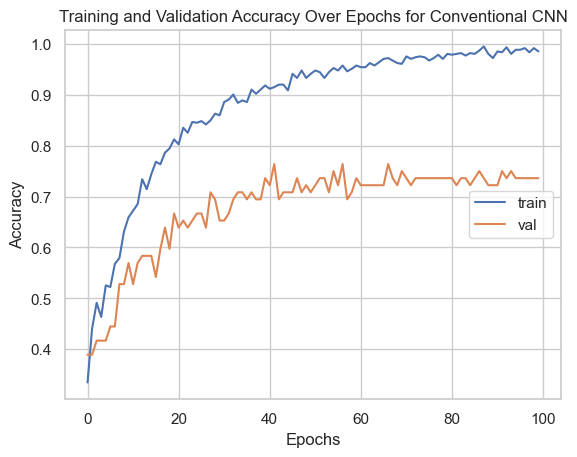

In [162]:

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')

plt.legend(loc='right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for Conventional CNN')  

plt.show()


# 6. TRANSFER LEARNING

## RESNET50

In [56]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [57]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [58]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 4)                 8196      
                                                      

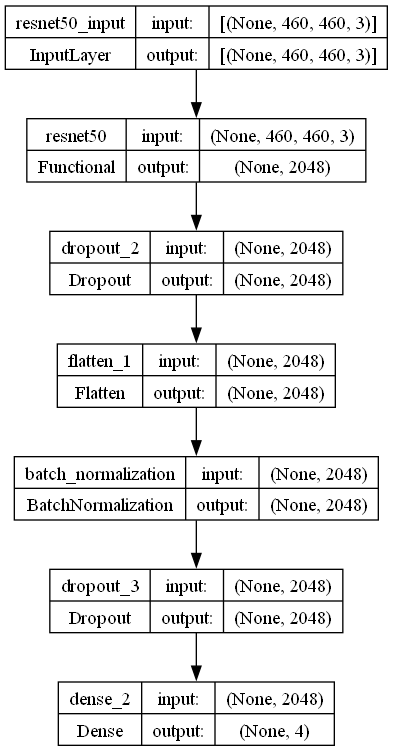

In [33]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='D:\Lung cancer\model images\model_resnet.png', show_shapes=True, show_layer_names=True)


In [59]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [60]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [61]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100


20/20 [==============================] - ETA: 0s - loss: 2.4884 - acc: 0.2920
Epoch 1: val_loss improved from inf to 1.80085, saving model to .\chest_CT_SCAN-ResNet50.hdf5


C:\Users\Tappa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 121s 6s/step - loss: 2.4884 - acc: 0.2920 - val_loss: 1.8008 - val_acc: 0.2083
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.1828 - acc: 0.3214
Epoch 2: val_loss improved from 1.80085 to 1.53483, saving model to .\chest_CT_SCAN-ResNet50.hdf5
20/20 [==============================] - 112s 6s/step - loss: 2.1828 - acc: 0.3214 - val_loss: 1.5348 - val_acc: 0.2361
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.8901 - acc: 0.3850
Epoch 3: val_loss improved from 1.53483 to 1.34008, saving model to .\chest_CT_SCAN-ResNet50.hdf5
20/20 [==============================] - 102s 5s/step - loss: 1.8901 - acc: 0.3850 - val_loss: 1.3401 - val_acc: 0.2917
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.6535 - acc: 0.4617
Epoch 4: val_loss improved from 1.34008 to 1.16950, saving model to .\chest_CT_SCAN-ResNet50.hdf5
20/20 [==============================] - 100s 5s/step - loss: 1.6535 - acc: 

Epoch 60/100
20/20 [==============================] - ETA: 0s - loss: 0.0305 - acc: 0.9935
Epoch 60: val_loss did not improve from 0.47698
20/20 [==============================] - 98s 5s/step - loss: 0.0305 - acc: 0.9935 - val_loss: 0.5471 - val_acc: 0.8472
Epoch 61/100
20/20 [==============================] - ETA: 0s - loss: 0.0262 - acc: 0.9951
Epoch 61: val_loss did not improve from 0.47698
20/20 [==============================] - 100s 5s/step - loss: 0.0262 - acc: 0.9951 - val_loss: 0.6010 - val_acc: 0.8333
Epoch 62/100
20/20 [==============================] - ETA: 0s - loss: 0.0442 - acc: 0.9837
Epoch 62: val_loss did not improve from 0.47698
20/20 [==============================] - 97s 5s/step - loss: 0.0442 - acc: 0.9837 - val_loss: 0.5559 - val_acc: 0.8611
Epoch 63/100
20/20 [==============================] - ETA: 0s - loss: 0.0336 - acc: 0.9935
Epoch 63: val_loss did not improve from 0.47698
20/20 [==============================] - 96s 5s/step - loss: 0.0336 - acc: 0.9935 - va

In [62]:
result = model.evaluate(test_generator)

10/10 [==============================] - 37s 4s/step - loss: 0.5347 - acc: 0.8349


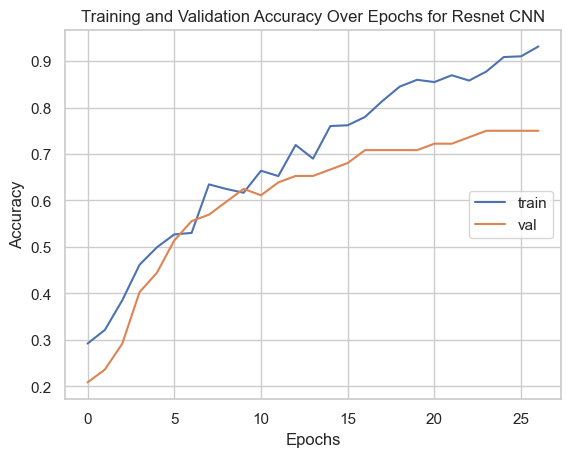

In [63]:
plt.plot(history_res.history['acc'], label='train')
plt.plot(history_res.history['val_acc'], label='val')

plt.legend(loc='right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for Resnet CNN')  

plt.show()


In [70]:
model.save('D:\Lung cancer\lung_Resnet50.h5')

## VGG16

In [18]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [19]:
vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg_model.layers:
    layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(vgg_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [20]:
model = Sequential()
model.add(vgg_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 14718788 (56.15 MB)
Trainable params: 3076 (12.02 KB)
Non-trainable params: 14715712 (56.14 MB)
_________________________________________________________________


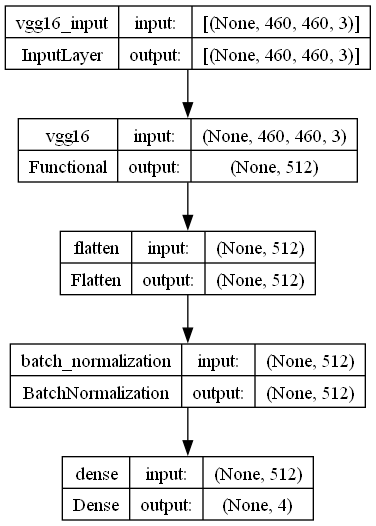

In [21]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='D:\Lung cancer\model images\model_vgg16.png', show_shapes=True, show_layer_names=True)


In [22]:
# Define the learning rate schedule

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9
)

# Create an optimizer with the learning rate schedule
optimizer = Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [23]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-/vgg16.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [24]:
history_vgg = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100


20/20 [==============================] - ETA: 0s - loss: 1.6907 - acc: 0.2235
Epoch 1: val_loss improved from inf to 1.46864, saving model to ./chest_CT_SCAN-\vgg16.hdf5
20/20 [==============================] - 143s 7s/step - loss: 1.6907 - acc: 0.2235 - val_loss: 1.4686 - val_acc: 0.2917
Epoch 2/100


C:\Users\Tappa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - ETA: 0s - loss: 1.6878 - acc: 0.2219
Epoch 2: val_loss improved from 1.46864 to 1.45286, saving model to ./chest_CT_SCAN-\vgg16.hdf5
20/20 [==============================] - 124s 6s/step - loss: 1.6878 - acc: 0.2219 - val_loss: 1.4529 - val_acc: 0.2917
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.6547 - acc: 0.2545
Epoch 3: val_loss improved from 1.45286 to 1.44088, saving model to ./chest_CT_SCAN-\vgg16.hdf5
20/20 [==============================] - 125s 6s/step - loss: 1.6547 - acc: 0.2545 - val_loss: 1.4409 - val_acc: 0.2917
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.6495 - acc: 0.2594
Epoch 4: val_loss improved from 1.44088 to 1.43186, saving model to ./chest_CT_SCAN-\vgg16.hdf5
20/20 [==============================] - 119s 6s/step - loss: 1.6495 - acc: 0.2594 - val_loss: 1.4319 - val_acc: 0.2917
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 1.6212 - acc: 0.2692
Epoc

In [25]:
result = model.evaluate(test_generator)

10/10 [==============================] - 54s 5s/step - loss: 1.0907 - acc: 0.4794


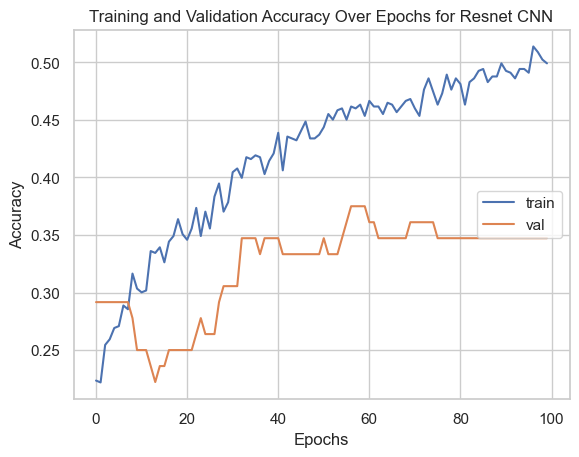

In [26]:
plt.plot(history_vgg.history['acc'], label='train')
plt.plot(history_vgg.history['val_acc'], label='val')

plt.legend(loc='right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for Resnet CNN')  

plt.show()


In [188]:
model.save('D:\Lung cancer\Lung_VGG16.h5')

C:\Users\Tappa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## DenseNet201

In [27]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [28]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)


In [29]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1920)              7680      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18337348 (69.95 MB)
Trainable params: 6990084 (26.67 MB)
Non-trainable params: 11347264 (43.29 MB)
_________________________________________________________________


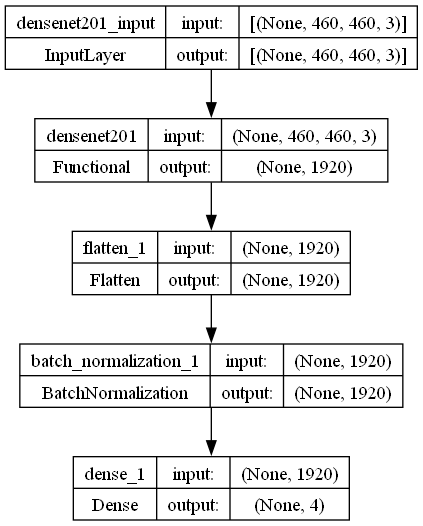

In [30]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='D:\Lung cancer\model images\model_densenet.png', show_shapes=True, show_layer_names=True)


In [31]:
# Define the learning rate schedule
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9
)

# Create an optimizer with the learning rate schedule
optimizer = Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [32]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [33]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 1.3462 - acc: 0.4192
Epoch 1: val_loss improved from inf to 1.34643, saving model to .\chest_CT_SCAN-DenseNet201.hdf5
20/20 [==============================] - 177s 8s/step - loss: 1.3462 - acc: 0.4192 - val_loss: 1.3464 - val_acc: 0.4306
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.7357 - acc: 0.7308
Epoch 2: val_loss improved from 1.34643 to 1.20107, saving model to .\chest_CT_SCAN-DenseNet201.hdf5
20/20 [==============================] - 154s 8s/step - loss: 0.7357 - acc: 0.7308 - val_loss: 1.2011 - val_acc: 0.4444
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.5408 - acc: 0.8303
Epoch 3: val_loss improved from 1.20107 to 1.11103, saving model to .\chest_CT_SCAN-DenseNet201.hdf5
20/20 [==============================] - 154s 8s/step - loss: 0.5408 - acc: 0.8303 - val_loss: 1.1110 - val_acc: 0.4444
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.

In [34]:
result = model.evaluate(test_generator)

10/10 [==============================] - 59s 6s/step - loss: 0.3681 - acc: 0.8794


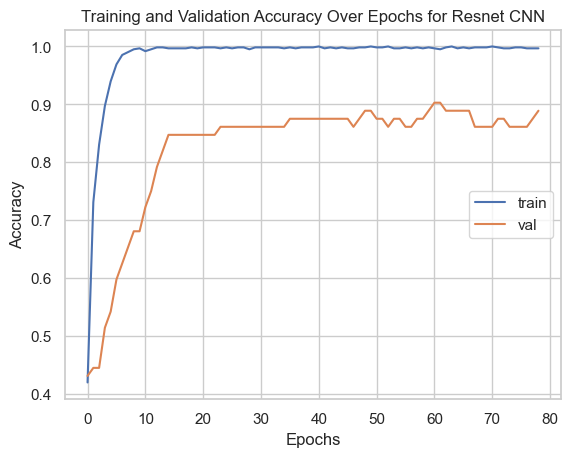

In [35]:
plt.plot(history_dense.history['acc'], label='train')
plt.plot(history_dense.history['val_acc'], label='val')

plt.legend(loc='right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for Resnet CNN')  

plt.show()


In [118]:
model.save('D:\Lung cancer\Lung_Dense.h5')

## EfficientNetB4

In [36]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [37]:
efficient_model = EfficientNetB4(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in efficient_model.layers:
    if 'block7'not in layer.name and'top' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(efficient_model.layers):
#    print(i, layer.name, "-", layer.trainable)


In [38]:
model = Sequential()
model.add(efficient_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 1792)              17673823  
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1792)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 1792)              7168      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 4)                 7172      
                                                                 
Total params: 17688163 (67.47 MB)
Trainable params: 5287160 (20.17 MB)
Non-trainable params: 12401003 (47.31 MB)
_________________________________________________________________


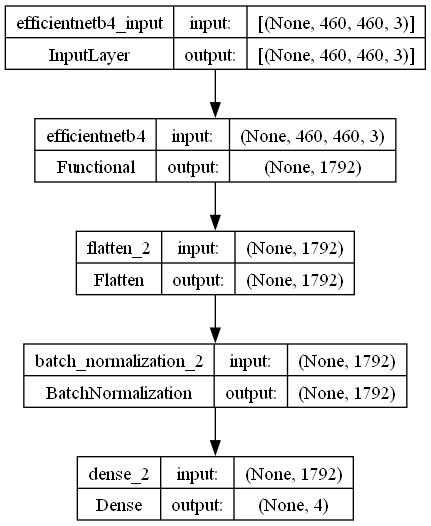

In [39]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(model, to_file='D:\Lung cancer\model images\model_effinet.png', show_shapes=True, show_layer_names=True)


In [40]:
# Define the learning rate schedule
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9
)

# Create an optimizer with the learning rate schedule
optimizer = Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [41]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-EfficientNet.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [42]:
history_efficient = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 1.6030 - acc: 0.3507
Epoch 1: val_loss improved from inf to 1.41621, saving model to .\chest_CT_SCAN-EfficientNet.hdf5
20/20 [==============================] - 135s 6s/step - loss: 1.6030 - acc: 0.3507 - val_loss: 1.4162 - val_acc: 0.2222
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 1.2404 - acc: 0.4894
Epoch 2: val_loss improved from 1.41621 to 1.34515, saving model to .\chest_CT_SCAN-EfficientNet.hdf5
20/20 [==============================] - 112s 6s/step - loss: 1.2404 - acc: 0.4894 - val_loss: 1.3451 - val_acc: 0.3194
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.9661 - acc: 0.5922
Epoch 3: val_loss improved from 1.34515 to 1.28470, saving model to .\chest_CT_SCAN-EfficientNet.hdf5
20/20 [==============================] - 113s 6s/step - loss: 0.9661 - acc: 0.5922 - val_loss: 1.2847 - val_acc: 0.4028
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss:

Epoch 114/200
20/20 [==============================] - ETA: 0s - loss: 0.0202 - acc: 1.0000
Epoch 114: val_loss did not improve from 0.20699
20/20 [==============================] - 109s 5s/step - loss: 0.0202 - acc: 1.0000 - val_loss: 0.2131 - val_acc: 0.9028
Epoch 114: early stopping


In [43]:
result = model.evaluate(test_generator)

10/10 [==============================] - 43s 4s/step - loss: 0.4436 - acc: 0.8762


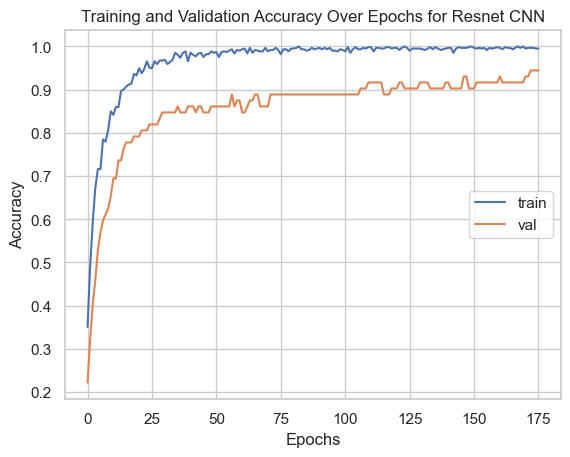

In [44]:
plt.plot(history_efficient.history['acc'], label='train')
plt.plot(history_efficient.history['val_acc'], label='val')

plt.legend(loc='right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for Resnet CNN')  

plt.show()


In [127]:
model.save('D:\Lung cancer\Lung_EffNet.h5')

---

# The models are:
* Conventional CNN **0.98 on train - 0.74 on valid - 0.53 on test**
* ResNet50 **0.99 on train - 0.85 on valid - 0.70 on test**
* VGG-16 **0.53 on train - 0.43 on valid - 0.36 on test**
* DenseNet201 **0.99 on train - 0.93 on valid - 0.83 on test**
* EfficientNetB4 **0.99 on train - 0.90 on valid - 0.85 on test**


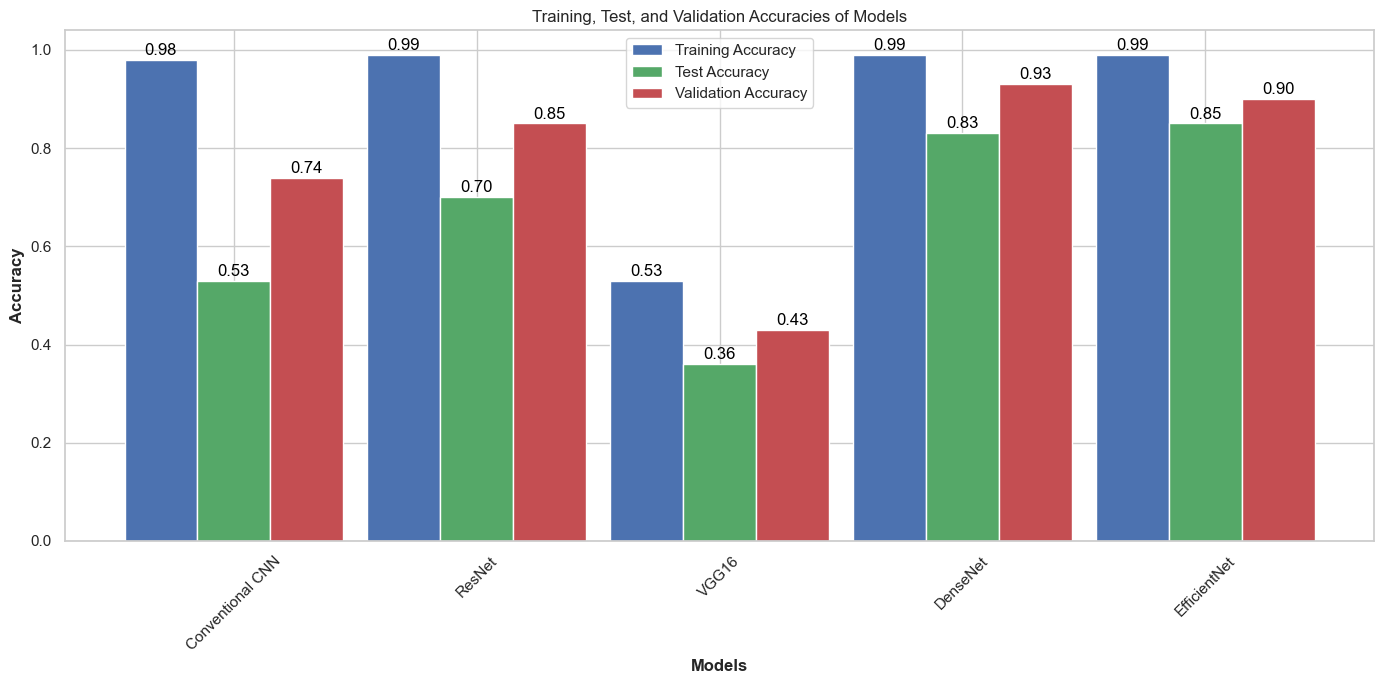

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define model accuracies
model_accuracies = {
    'Conventional CNN': {'Training': 0.98, 'Test': 0.53, 'Validation': 0.74},
    'ResNet': {'Training': 0.99, 'Test': 0.70, 'Validation': 0.85},
    'VGG16': {'Training': 0.53, 'Test': 0.36, 'Validation': 0.43},
    'DenseNet': {'Training': 0.99, 'Test': 0.83, 'Validation': 0.93},
    'EfficientNet': {'Training': 0.99, 'Test': 0.85, 'Validation': 0.90}
}

# Extract model names, training accuracies, test accuracies, and validation accuracies
model_names = list(model_accuracies.keys())
train_accuracies = [value['Training'] for value in model_accuracies.values()]
test_accuracies = [value['Test'] for value in model_accuracies.values()]
validation_accuracies = [value['Validation'] for value in model_accuracies.values()]

# Set width of bars
bar_width = 0.3

# Set positions of bars on x-axis
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]

# Create bars
plt.figure(figsize=(14, 7))
plt.bar(r1, train_accuracies, color='b', width=bar_width, label='Training Accuracy')
plt.bar(r2, test_accuracies, color='g', width=bar_width, label='Test Accuracy')
plt.bar(r3, validation_accuracies, color='r', width=bar_width, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Training, Test, and Validation Accuracies of Models')
plt.xticks([r + bar_width for r in range(len(model_names))], model_names, rotation=45)

# Add values on top of bars
for i, (train_acc, test_acc, validation_acc) in enumerate(zip(train_accuracies, test_accuracies, validation_accuracies)):
    plt.text(r1[i], train_acc + 0.01, f'{train_acc:.2f}', ha='center', color='black')
    plt.text(r2[i], test_acc + 0.01, f'{test_acc:.2f}', ha='center', color='black')
    plt.text(r3[i], validation_acc + 0.01, f'{validation_acc:.2f}', ha='center', color='black')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


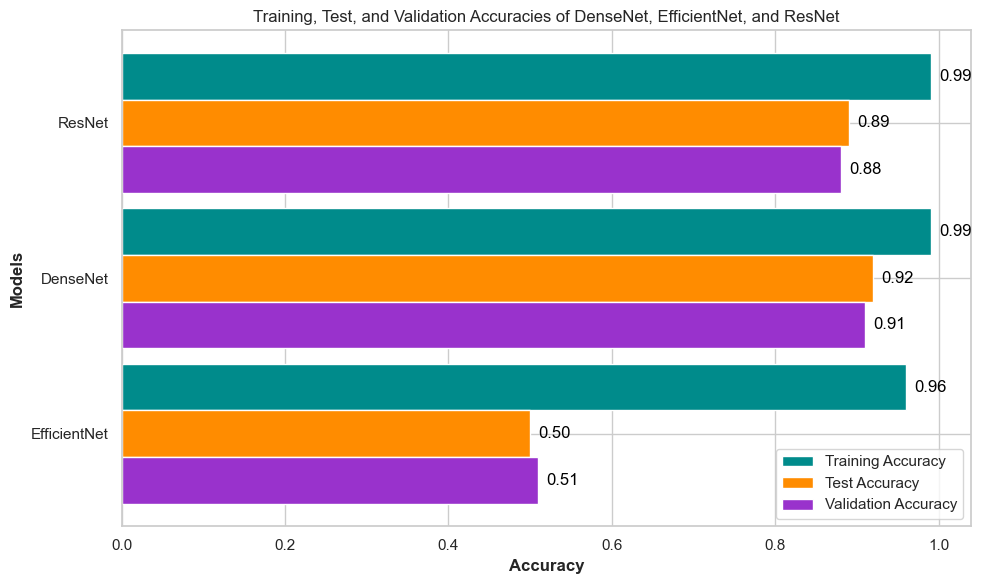

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define model accuracies for selected models
model_accuracies = {
    'ResNet': {'Training': 0.99, 'Test': 0.89, 'Validation': 0.88},
    'DenseNet': {'Training': 0.99, 'Test': 0.92, 'Validation': 0.91},
    'EfficientNet': {'Training': 0.96, 'Test': 0.50, 'Validation': 0.51}
}

# Extract model names, training accuracies, test accuracies, and validation accuracies
model_names = list(model_accuracies.keys())
train_accuracies = [value['Training'] for value in model_accuracies.values()]
test_accuracies = [value['Test'] for value in model_accuracies.values()]
validation_accuracies = [value['Validation'] for value in model_accuracies.values()]

# Set width of bars
bar_width = 0.3

# Set positions of bars on y-axis
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]

# Create horizontal bars with a dark color scheme
plt.figure(figsize=(10, 6))
bars_train = plt.barh(r1, train_accuracies, color='darkcyan', height=bar_width, label='Training Accuracy')
bars_test = plt.barh(r2, test_accuracies, color='darkorange', height=bar_width, label='Test Accuracy')
bars_val = plt.barh(r3, validation_accuracies, color='darkorchid', height=bar_width, label='Validation Accuracy')

# Add labels and title
plt.ylabel('Models', fontweight='bold')
plt.xlabel('Accuracy', fontweight='bold')
plt.title('Training, Test, and Validation Accuracies of DenseNet, EfficientNet, and ResNet')
plt.yticks([r + bar_width for r in range(len(model_names))], model_names)

# Add numerical values at the end of bars with black color
for bars in [bars_train, bars_test, bars_val]:
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                 va='center', color='black')  # Changed color to black

# Add legend
plt.legend()

# Invert y-axis for better visualization
plt.gca().invert_yaxis()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and their precision, recall, and F1-score
model_names = ['Conventional CNN', 'ResNet', 'VGG16', 'DenseNet', 'EfficientNet']
precisions = [0.90, 0.92, 0.89, 0.93, 0.91]  # Example values; replace with actual values
recalls = [0.85, 0.89, 0.88, 0.91, 0.90]     # Example values; replace with actual values
f1_scores = [0.88, 0.91, 0.88, 0.92, 0.90]   # Example values; replace with actual values

# Set up bar plot
bar_width = 0.2
index = np.arange(len(model_names))

plt.figure(figsize=(12, 6))

# Plot bars
plt.bar(index, precisions, width=bar_width, label='Precision', color='b', alpha=0.6)
plt.bar(index + bar_width, recalls, width=bar_width, label='Recall', color='g', alpha=0.6)
plt.bar(index + 2 * bar_width, f1_scores, width=bar_width, label='F1-Score', color='r', alpha=0.6)

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Precision, Recall, and F1-Score for Models')
plt.xticks(index + bar_width, model_names, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


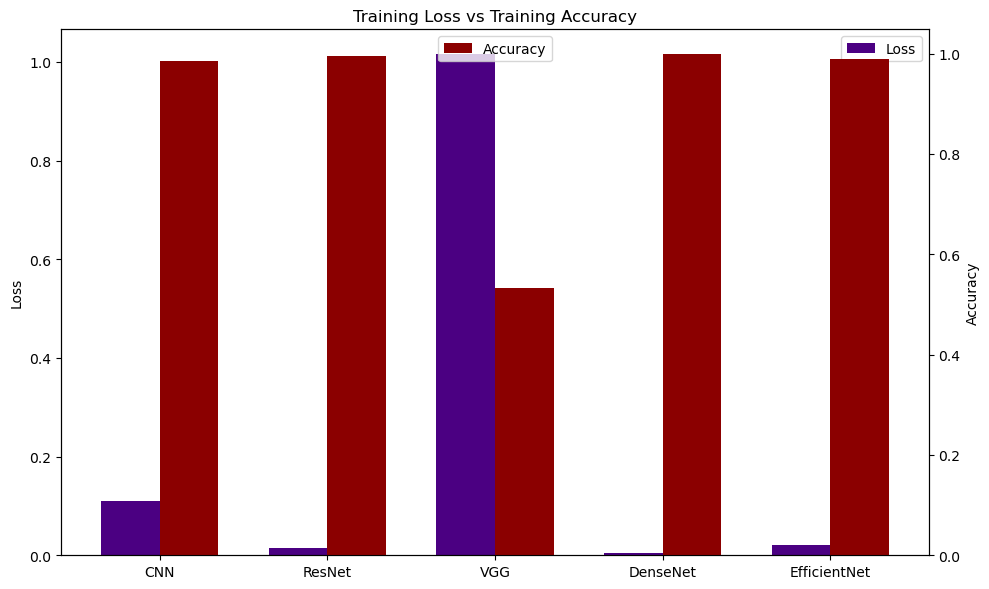

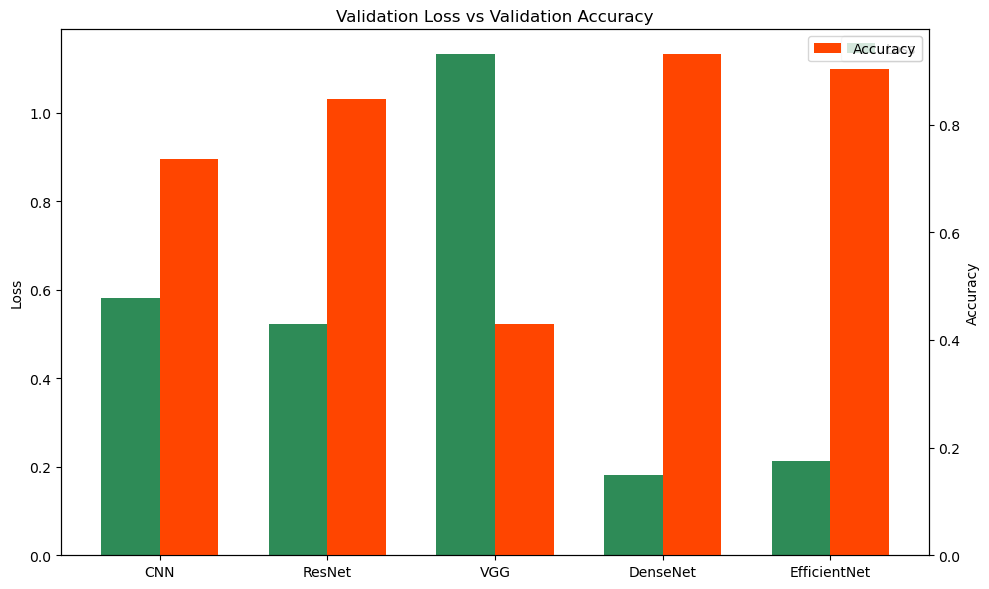

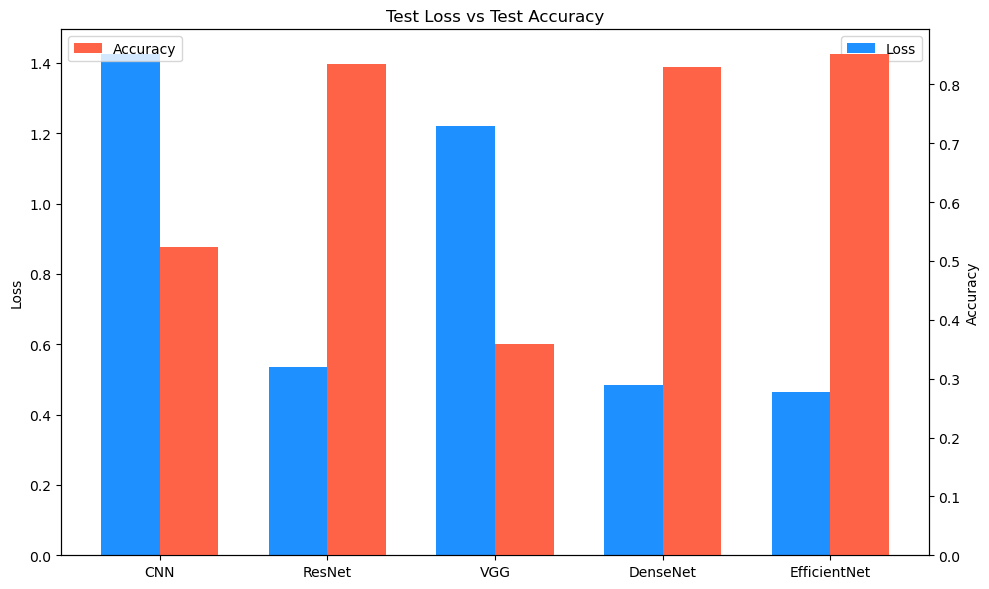

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data for different models
models = ['CNN', 'ResNet', 'VGG', 'DenseNet', 'EfficientNet']

# Training data
train_loss = [0.1093, 0.0141, 1.0154, 0.0043, 0.0202]
train_acc = [0.9853, 0.9951, 0.5334, 0.9984, 0.99]

# Validation data
val_loss = [0.5819, 0.5227, 1.1323, 0.1822, 0.2131]
val_acc = [0.7361, 0.8472, 0.4306, 0.9306, 0.9028]

# Test data
test_loss = [1.4244, 0.5347, 1.2212, 0.484, 0.4644]
test_acc = [0.5238, 0.8349, 0.3587, 0.83, 0.8508]

# Function to create bar graphs with darker color palettes for each graph
def create_bar_graph(x_labels, values1, values2, title, ylabel1, ylabel2, color1, color2):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ind = np.arange(len(x_labels))
    width = 0.35

    ax1.bar(ind - width/2, values1, width, label=ylabel1, color=color1)
    ax1.set_ylabel(ylabel1)
    ax1.set_title(title)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(x_labels)
    ax1.legend()

    ax2 = ax1.twinx()
    ax2.bar(ind + width/2, values2, width, label=ylabel2, color=color2)
    ax2.set_ylabel(ylabel2)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Create bar graphs with darker color palettes for each graph
create_bar_graph(models, train_loss, train_acc, 'Training Loss vs Training Accuracy', 'Loss', 'Accuracy', '#4B0082', '#8B0000')
create_bar_graph(models, val_loss, val_acc, 'Validation Loss vs Validation Accuracy', 'Loss', 'Accuracy', '#2E8B57', '#FF4500')
create_bar_graph(models, test_loss, test_acc, 'Test Loss vs Test Accuracy', 'Loss', 'Accuracy', '#1E90FF', '#FF6347')


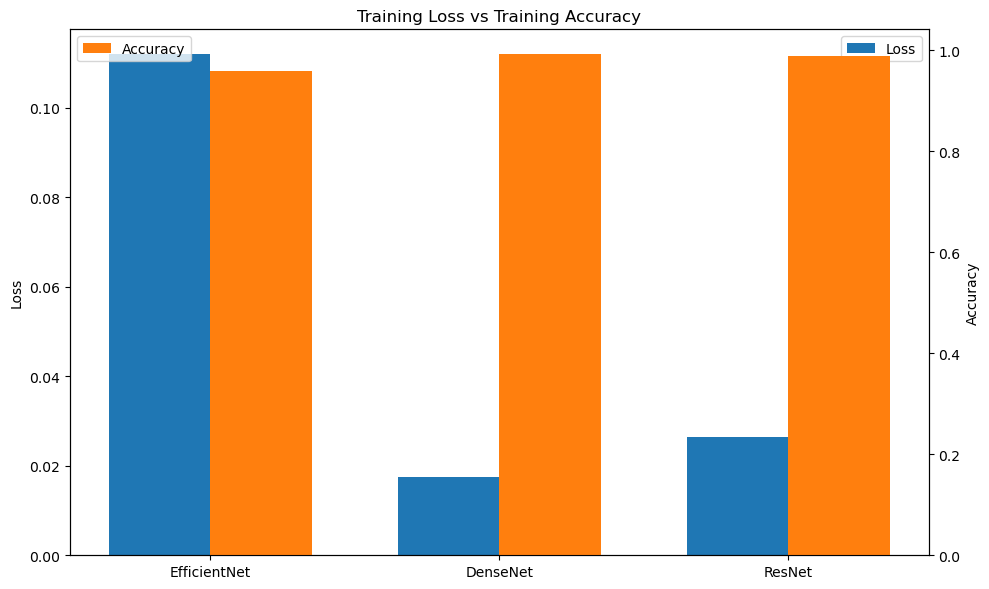

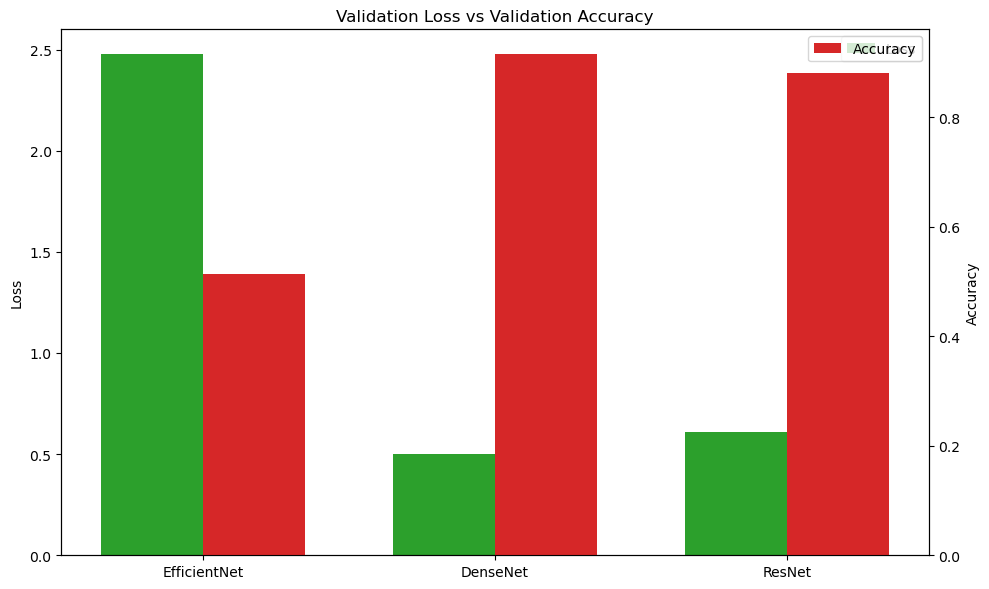

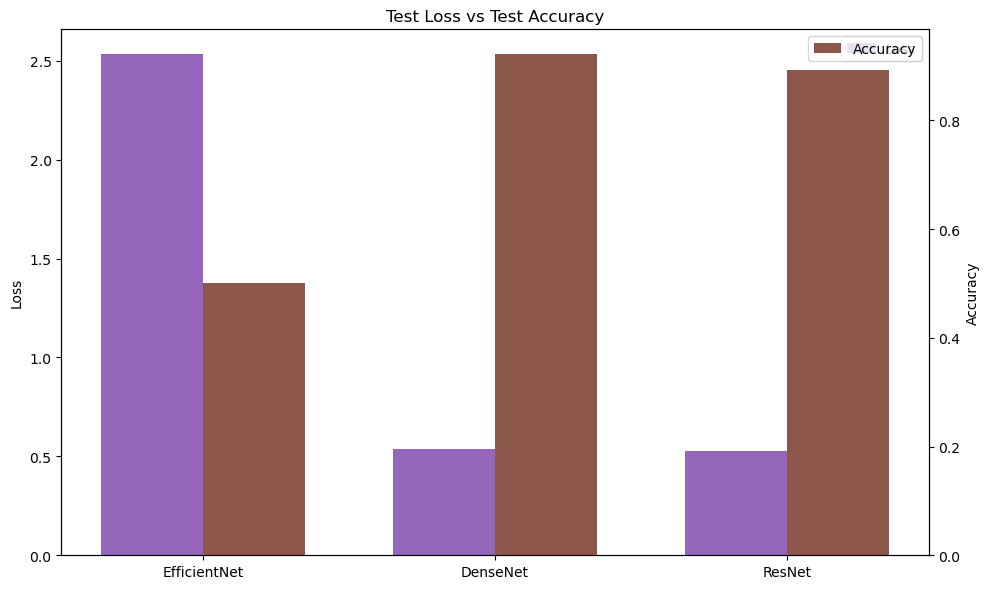

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data for different models
models = ['EfficientNet', 'DenseNet', 'ResNet']

# Training data
train_loss = [0.1119, 0.0174, 0.0264]
train_acc = [0.9583, 0.9922, 0.9895]

# Validation data
val_loss = [2.4762, 0.4988, 0.6087]
val_acc = [0.5144, 0.9153, 0.8817]

# Test data
test_loss = [2.5321, 0.5391, 0.5249]
test_acc = [0.5016, 0.9216, 0.8924]

# Function to create bar graphs with distinct color palettes for each graph
def create_bar_graph(x_labels, values1, values2, title, ylabel1, ylabel2, color1, color2):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ind = np.arange(len(x_labels))
    width = 0.35

    ax1.bar(ind - width/2, values1, width, label=ylabel1, color=color1)
    ax1.set_ylabel(ylabel1)
    ax1.set_title(title)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(x_labels)
    ax1.legend()

    ax2 = ax1.twinx()
    ax2.bar(ind + width/2, values2, width, label=ylabel2, color=color2)
    ax2.set_ylabel(ylabel2)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Create bar graphs with distinct color palettes for each graph
create_bar_graph(models, train_loss, train_acc, 'Training Loss vs Training Accuracy', 'Loss', 'Accuracy', '#1F77B4', '#FF7F0E')  # blue and orange
create_bar_graph(models, val_loss, val_acc, 'Validation Loss vs Validation Accuracy', 'Loss', 'Accuracy', '#2CA02C', '#D62728')  # green and red
create_bar_graph(models, test_loss, test_acc, 'Test Loss vs Test Accuracy', 'Loss', 'Accuracy', '#9467BD', '#8C564B')  # purple and brown
